In [12]:
from datasets import load_dataset

dataset = load_dataset("xhiroga/MiniAlbum")

In [13]:
PIZZA_LABEL = 1
pizzas = dataset["train"].filter(lambda example: example["label"] == PIZZA_LABEL)

In [14]:
from torchvision import transforms
resize = transforms.Resize((224, 224))
resized = pizzas.map(lambda example: {"image": resize(example["image"])}, batched=False)

In [18]:
# Normalize the images to match with the ResNet model
compose = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
composed = resized.map(lambda example: {"image": compose(example["image"])}, batched=False)

In [19]:
from torch.utils.data import DataLoader
composed.set_format("torch")
dataloder = DataLoader(composed)

In [17]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from torchvision import transforms
import numpy as np
import torch

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
# Note: input_tensor can be a batch tensor with several images!
batch = next(iter(dataloder))
input_tensor = batch["image"]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...`````

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(963)] # Pizza

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

rgb_img = np.array(resized[1]["image"]) / 255.0 # (height, width, channel) の順である必要がある。ex. 224, 224, 3

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

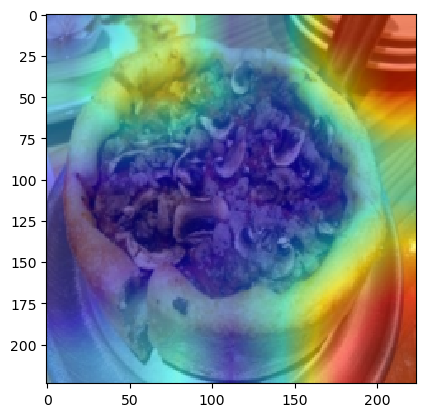

In [92]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(visualization, vmin=0, vmax=255, interpolation='none')
plt.show()